In [1]:
!pip install torch torchvision

Load VGG Pretrained Model

In [2]:
import torch
from torchvision import models

vgg = models.vgg19(pretrained = True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/jovyan/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [3]:
# We wont be using the clssifier the style are from the CNN
vgg = vgg.features

In [4]:
#  not updating the model its freezed weights not updated no gradient coputation
for parameters in vgg.parameters():
  parameters.requires_grad_(False)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

Preprocess image

In [7]:
from PIL import Image
from torchvision import transforms as T

def preprocess (img_path, max_size = 500):
  image = Image.open(img_path).convert('RGB')

  if max(image.size)>max_size:
    size = max_size

  else:
    size = max(image.size)
# these are stnadard transforms expected by the model
  img_transforms = T.Compose([
      T.Resize(size),
      T.ToTensor(),  #(224,224,3) -> (3,224,224)
      T.Normalize(mean = [0.485,0.456,0.406],
                  std = [0.229, 0.224, 0.225])
  ])

  image = img_transforms(image)
  image = image.unsqueeze(0)    #(224,224,3) -> (1,3,224,224)

  # unsqueeze will add 1 number at 0th place 

  return image

In [27]:
content_p = preprocess('content.jpg.jpg')
style_p = preprocess('skye.jpg')

content_p = content_p.to(device)
style_p = style_p.to(device)

print("Content Shape",content_p.shape )
print("Style Shape",style_p.shape )

Content Shape torch.Size([1, 3, 500, 500])
Style Shape torch.Size([1, 3, 500, 888])


Deprocess image

In [28]:
import numpy as np
import matplotlib.pyplot as plt

def deprocess(tensor):
  image = tensor.to('cpu').clone()
  image = image.numpy()
  image = image.squeeze(0)  #(1,3,224,224) -> (3,224,224)
  image = image.transpose(1,2,0)  #(3,224,224) -> (224,224,3)
  image = image*np.array([0.229, 0.224, 0.225]) + np.array([0.485,0.456,0.406])
  image = image.clip(0,1)
  return image

In [29]:
content_d = deprocess(content_p)
style_d = deprocess(style_p)

print("Deprocess Content : ", content_d.shape)
print("Deprocess Style : ", style_d.shape)

Deprocess Content :  (500, 500, 3)
Deprocess Style :  (500, 888, 3)


In [30]:
content_d = deprocess(content_p)
style_d = deprocess(style_p)

print("Deprocess Content : ", content_d.shape)
print("Deprocess Style : ", style_d.shape)

Deprocess Content :  (500, 500, 3)
Deprocess Style :  (500, 888, 3)


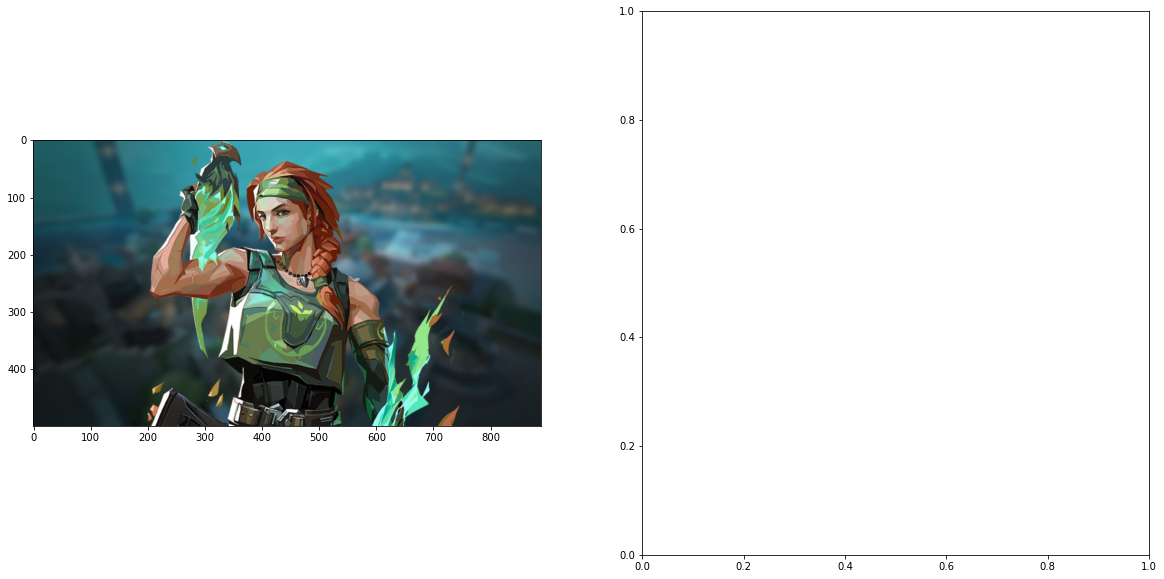

In [31]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,10))
ax1.imshow (content_d)
ax1.imshow (style_d)

In [32]:
def get_features (image, model):
#Extracting style and content features to the names in the table 
  layers = {
      
            '0' : 'conv1_1',
            '5' : 'conv2_1',
            '10' : 'conv3_1',
            '19' : 'conv4_1',
            '21' : 'conv4_2', # content feature otherare style
            '28' : 'conv5_1'
  }

  x= image

  Features ={}

  for name, layer in model._modules.items():
    x= layer(x)

    if name in layers:
      Features[layers[name]]=x
    
  return Features

In [33]:
content_f= get_features(content_p,vgg)
style_f= get_features(style_p,vgg)

In [34]:
def gram_matrix (tensor):
  b,c,h,w = tensor.size()
  tensor = tensor.view(c,h*w)
  gram = torch.mm(tensor,tensor.t())
  return gram

In [35]:
style_grams = {layer : gram_matrix(style_f[layer]) for layer in style_f}

Creating Style and Content loss function

In [36]:
def content_loss(target_conv4_2, content_conv4_2):
  loss = torch.mean((target_conv4_2-content_conv4_2)**2)
  return loss

In [37]:
style_weights = {
    'conv1_1' : 1.0,
    'conv2_1' : 0.75,
    'conv3_1' : 0.2,
    'conv4_1' : 0.2,
    'conv5_1' : 0.2,
}

In [38]:
def style_loss (style_weights, target_features, style_grams):
  loss = 0

  for layer in style_weights:
    target_f = target_features[layer]
    target_gram = gram_matrix(target_f)
    style_gram = style_grams[layer]
    b,c,h,w = target_f.shape
    layer_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
    loss += layer_loss/(c*h*w)
 
  return loss

In [39]:
target = content_p.clone().requires_grad_(True).to(device)
target_f = get_features(target,vgg)

print("Content Loss: ", content_loss(target_f['conv4_2'],content_f['conv4_2']))
print("Style Loss: ", style_loss(style_weights,target_f,style_grams))


Content Loss:  tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
Style Loss:  tensor(659.1342, device='cuda:0', grad_fn=<AddBackward0>)


Training loop

In [40]:
from torch import optim

optimizer = optim.Adam([target],lr = 0.003)

alpha =1
beta = 1e5

epochs = 3000
show_every = 500

In [41]:
def total_loss(c_loss,s_loss,alpha,beta):
  loss = alpha * c_loss + beta * s_loss

  return loss
  

In [42]:
results = []

for i in range(epochs):
  target_f = get_features(target,vgg)

  c_loss = content_loss(target_f['conv4_2'], content_f['conv4_2'])
  s_loss = style_loss(style_weights,target_f,style_grams)
  t_loss = total_loss(c_loss, s_loss,alpha,beta)

  optimizer.zero_grad()
  t_loss.backward()
  optimizer.step()

  if i% show_every == 0:
    print("Total loss at epoch {} : {}".format(i,t_loss))
    results.append(deprocess(target.detach()))

Total loss at epoch 0 : 65913420.0
Total loss at epoch 500 : 3559147.0
Total loss at epoch 1000 : 1658704.875
Total loss at epoch 1500 : 1302179.0
Total loss at epoch 2000 : 1105219.125
Total loss at epoch 2500 : 968839.5


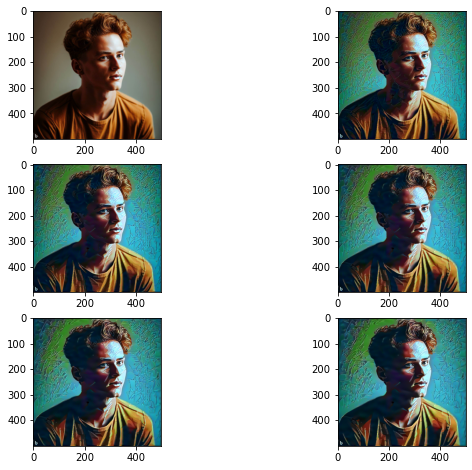

In [43]:
plt.figure(figsize = (10,8))

for i in range(len(results)):

  plt.subplot(3,2,i+1)
  plt.imshow(results[i])
plt.show()

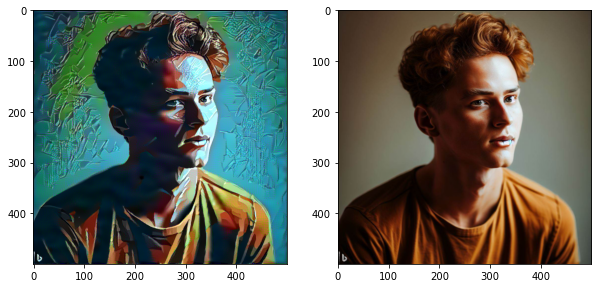

In [44]:
target_copy = deprocess(target.detach())
content_copy = deprocess(content_p)

fig,(ax1,ax2) =plt.subplots(1,2,figsize = (10,5))
ax1.imshow(target_copy)
ax2.imshow(content_copy)

In [ ]:
# print(torch. __version__)